# Image Classification

This notebook uses the [FastAI course](https://course.fast.ai/) as reference.

Here are the categories we'll be modeling in this notebook:<br>
- Men's shoes (shoes_men)
- Women's shoes (shoes_women)
- Socks (socks)
- Leggings (leggings)

## Preliminaries

Import the needed packages. Note the important import here is `from fastai.vision import *`

In [1]:
import os
import warnings

from fastai.callbacks import SaveModelCallback
from fastai.metrics import error_rate
from fastai.vision import *
from itertools import chain
from pathlib import Path

warnings.filterwarnings('ignore') # Ignore warning messages

In this cell, we define our image categories, a list of url files (which we'll get soon), and the path where we want to store/access the data.

In [2]:
categories = ['shoes_women', 'shoes_men', 'socks', 'leggings']
url_files = ['urls_' + categ + '.csv' for categ in categories]
path = Path('data/footwear')

## Image Scraping from Google Image Search

### Download image urls

Here are the steps to **create a csv of image urls** from google search. Note that you have to **repeat this for every category** you want images of.
1. Go to [Google Images](http://images.google.com) and **search for the categories** you are interested in. The more specific, the better. To ensure good search results, try excluding terms, for example:
    > **leggings -socks** : means you're searching for leggings but NOT socks
    
1. In case you only want small/medium images, limit the sizes by clicking on Tools > Icon/Medium.
    
1. **Scroll down until you've seen all the images you want to download**, or until you see a button saying 'Show more results'. All the images you scrolled past are now available to download. If you want more images, click on 'Show more results' and continue scrolling.
1. For Google Chrome, **press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd>** on Windows or **<kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd>** on Mac, and the javascript 'Console' will appear.
1. Copy paste this code into the console:
```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```
1. A small file should download. Rename it to 'urls_\[category\].csv'

### Directory preparation

This is the typical way of storing computer vision data:
- Create separate folders for train, test, and validation datasets
- In each of those folders, create a folder for each of the categories you have
- Place each image in its corresponding category folder.

Here is an example:
```
.
├── data
│   ├── train
│       ├── shoes_men
│       ├── shoes_women
│       ├── socks
│       ├── leggings
│   ├── valid (same structure as train)
│   ├── test (same structure as train)```


For our case, we will only create folders for each category, since FastAI can make validation and test sets for us.
```
.
├── data
│   ├── footwear
│       ├── shoes_men
│       ├── shoes_women
│       ├── socks
│       ├── leggings
```

We make folders for each of our categories, where we'll store the downloaded images. <br>

In [7]:
for categ in categories:
    dest = path/categ
    dest.mkdir(parents=True, exist_ok=True)

We also place all of our 'urls_\[category\].csv' files in the same level as our category folders.

In [8]:
path.ls()

[WindowsPath('data/footwear/leggings'),
 WindowsPath('data/footwear/shoes_men'),
 WindowsPath('data/footwear/shoes_women'),
 WindowsPath('data/footwear/socks'),
 WindowsPath('data/footwear/urls_leggings.csv'),
 WindowsPath('data/footwear/urls_shoes_men.csv'),
 WindowsPath('data/footwear/urls_shoes_women.csv'),
 WindowsPath('data/footwear/urls_socks.csv')]

### Download images using url files

We then run this code to download all images from our url files for each of the categories.

In [77]:
for file, categ in zip(url_files, categories):
    print(categ)
    dest = path/categ
    download_images(path/file, dest, max_pics=700)
    verify_images(path/categ, delete=True, max_size=500)

shoes_women


shoes_men


socks


leggings


## Modeling

### Create a DataBunch

We will create an `ImageDataBunch`, which is an object containing the following:
- Our train, test, and validation datasets
- The transformations we'll be performing on our images
- Other important parameters such as image `size` and batch size `bs`

Note that if you encounter MemoryErrors, you may want to decrease image `size` or batch size `bs`. If you want your model to 'see' more details in your images, increase image `size`.

In [3]:
bs=32

We specify the following for our DataBunch, which we will generate from folders (hence `ImageDataBunch.from_folder`):
1. `path=path` - the directory containing our category folders. In this case it's `'data/footwear'`
2. `train-"."` - the directory containing our training data. We specify `'.'` since our validation data will be coming from our training data.
3. `valid_pct=0.2` - the percentage of our training data that we want to hold out for validation.
    - Note that if your images are split into 'train', 'test', and 'valid' folders, you should specify the file paths of these folder instead of specifying a value for `valid_pct`.
4. `ds_tfms=get_transforms()` - the transforms we want to apply to our dataset. `get_transforms()` is a FastAI function that gets a list of typical transforms used (rotation, zooming, translation, etc).
5. `bs=bs` - the batch size we want to use in modeling (multiple images are processed at the same time)
6. `size=224` - the image size, which we specify as 224x224

We also normalize our pixel values using statistics from imagenet, through `.normalize(imagenet_stats)`

In [4]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path,
                                  train=".",
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(),
                                  bs=bs,
                                  size=224
                                    ).normalize(imagenet_stats)

In [5]:
data.classes

['leggings', 'shoes_men', 'shoes_women', 'socks']

We use the function `.show_batch()` to show sample images from our DataBunch.

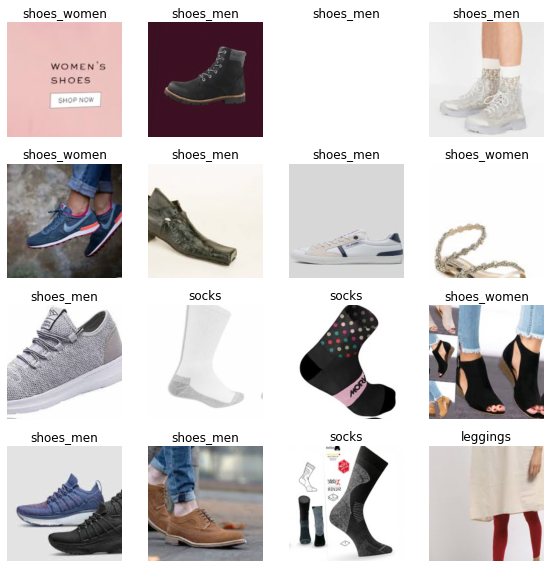

In [6]:
data.show_batch(rows=4, figsize=(8,8))

### Create a Learner (a neural net model)

The function to define a CNN is `cnn_learner()`, though there is a more general function called `Learner()` if you want to create a more advanced model.<br>

We will use weights from `models.resnet50`, which are weights pretrained on the ImageNet dataset. We just have to tune these weights to the 'new' images we'll be feeding the model. <br>

Note that the line `learn.model.cuda()` makes our model train on GPU. You always want to do this (unless you have no GPU access), since this will make training **much** faster.

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

We will use Leslie Smith's **[1 Cycle Policy](https://arxiv.org/pdf/1803.09820.pdf)**, which is essentially a way to control our model's learning rate and momentum such that it trains fast, but does not overfit or get stuck in a saddle point. <br>
FastAI has implemented this through its `Learner.fit_one_cycle()` function, which fits your model on 1 Cycle using the number of epochs you specify. Below, we fit 1 Cycle over 10 epochs.

In [8]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.303267,0.797555,0.272374,01:22
1,1.019082,0.718676,0.245136,01:18
2,0.878435,0.639344,0.225681,01:19
3,0.726180,0.551344,0.210117,01:18
4,0.601773,0.548616,0.217899,01:17
5,0.511514,0.505609,0.202335,01:17
6,0.422099,0.446399,0.178988,01:17
7,0.365781,0.461301,0.217899,01:17
8,0.326806,0.449308,0.194553,01:20
9,0.289613,0.458108,0.186770,01:19


We then use FastAI's `Learner.save()`, which saves our model weights using the specified filename. Note that these are big files in the MB-GB range, depending on how many weights your model has.

In [9]:
learn.save('stage-1')

The function `Learner.unfreeze()` unfreezes weights in all layers of our neural network. We can use this to fine-tune our model on our current dataset.
1. We plot the 'LR Finder' curve, which tells us the optimal learning rate at which to train our unfrozen model. We should take the value at the region of **steepest descent**. In this example, it's around 1e-5 to 1e-4.
1. We fit another cycle, specifying the maximum learning rate as the value from the LR Finder plot. In case we want the model to train on only a certain region of the plot, we can pass `max_lr=slice(min_val, max_val)` - our model will use the min and max values we specify.

In [10]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


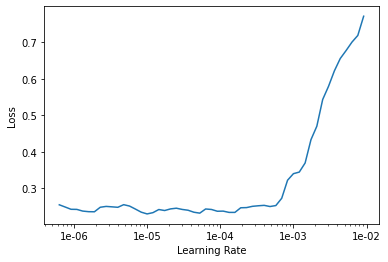

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.247169,0.442216,0.190661,01:23
1,0.234456,0.463489,0.210117,01:23
2,0.213014,0.483345,0.198444,01:21
3,0.189413,0.470113,0.194553,01:22
4,0.171666,0.463862,0.194553,01:22


In [13]:
learn.save('stage-2')

### Interpret model results

To interpret our model results, FastAI has a number of functions that can help us using the class `ClassificationInterpretation`:
1. `.plot_top_losses()` - plot the **'biggest mistakes'** the model made.
2. `.plot_confusion_matrix()` - plot the confusion matrix of our various categories.
3. `.most_confused()` - output a list of category pairs commonly mistaken for each other, such as men's shoes vs. women's shoes.

Most confused categories (Actual, Predicted, Count):
[('shoes_men', 'shoes_women', 26), ('shoes_women', 'shoes_men', 11)]


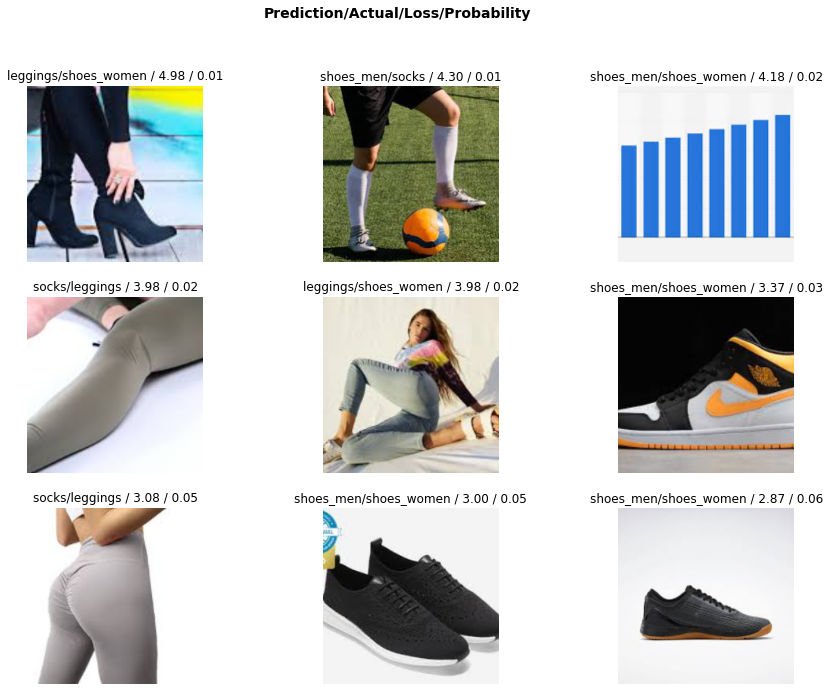

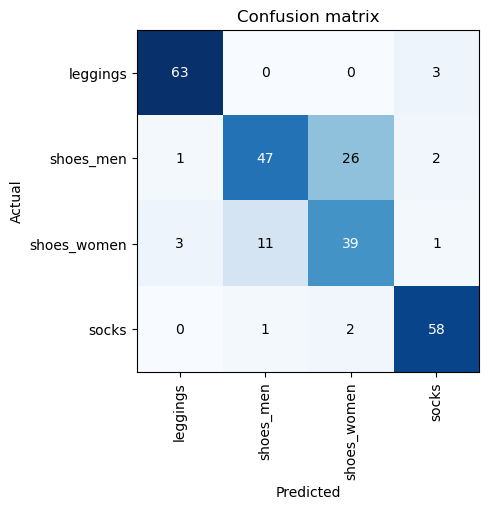

In [14]:
learn.load('stage-2')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize = (15,11))
interp.plot_confusion_matrix(figsize = (5,5), dpi = 100)
most_confused = interp.most_confused(min_val = 10)
print('Most confused categories (Actual, Predicted, Count):\n{}'.format(most_confused))

### Regularization techniques

In this section, we use several techniques that address overfitting/employ regularization in order to improve our model:
1. **Label smoothing** - we use decimal labels (0.9, 0.1) instead of integers (1, 0); this prevents the model from becoming overconfident
1. **Mixup** - we overlay pairs of images (with some transparency) to prevent overfitting
1. **Cutout** - we cut out random squares from images

Note that this is not an exhaustive list - there are many more regularization techniques for computer vision.

#### Mixup & Label Smoothing

In [15]:
learn = cnn_learner(data,
                    models.resnet50,
                    metrics=error_rate,
                    loss_func=LabelSmoothingCrossEntropy()).mixup()
learn.model.cuda()
learn.fit_one_cycle(10)
learn.save('ls_mixup_stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,1.983374,1.252211,0.322957,01:16
1,1.884665,1.513180,0.330739,01:16
2,1.652190,0.985631,0.287938,01:15
3,1.422023,0.861886,0.225681,01:15
4,1.245258,0.776687,0.256809,01:16
5,1.115094,0.750738,0.210117,01:19
6,1.048372,0.776655,0.245136,01:22
7,0.991124,0.712856,0.206226,01:17
8,0.949491,0.729394,0.249027,01:16
9,0.924917,0.729999,0.245136,01:16


In [17]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))
learn.save('ls_mixup_stage-2')

epoch,train_loss,valid_loss,error_rate,time
0,0.898339,0.715093,0.225681,01:22
1,0.884400,0.694812,0.178988,01:22
2,0.863506,0.692978,0.175097,01:21
3,0.860983,0.693234,0.175097,01:20
4,0.852246,0.695707,0.159533,01:20


Most confused categories (Actual, Predicted, Count):
[('shoes_men', 'shoes_women', 16), ('shoes_women', 'shoes_men', 12)]


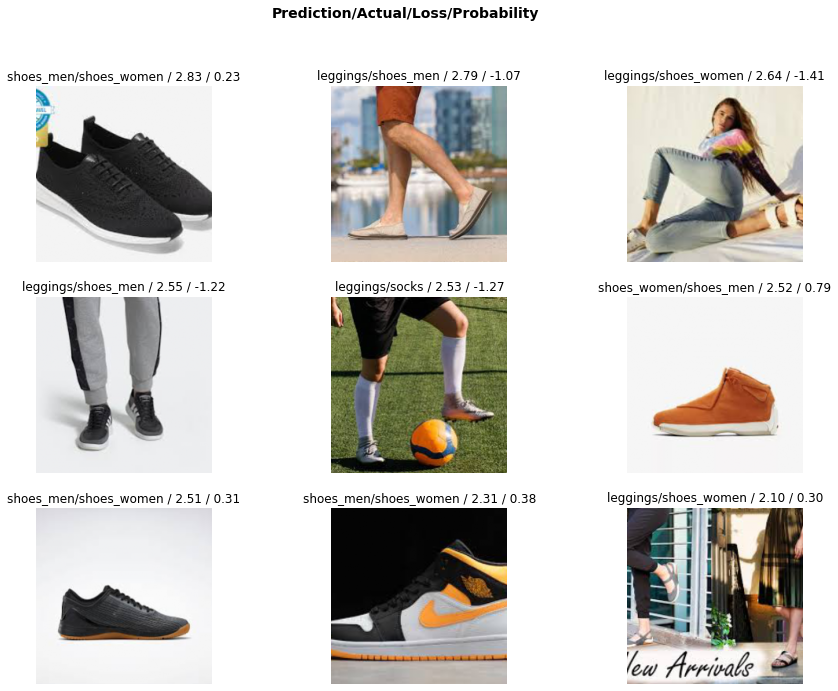

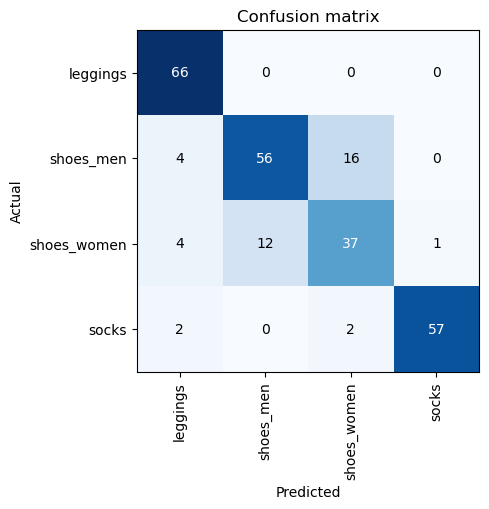

In [18]:
learn.load('ls_mixup_stage-2')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize = (15,11))
interp.plot_confusion_matrix(figsize = (5,5), dpi = 100)
most_confused = interp.most_confused(min_val = 10)
print('Most confused categories (Actual, Predicted, Count):\n{}'.format(most_confused))

#### Cutout

In [19]:
tfms = get_transforms(xtra_tfms = cutout(n_holes=(1,3)))
bs = 32

In [20]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path,
                                  train=".",
                                  valid_pct=0.2,
                                  ds_tfms=tfms,
                                  bs=bs,
                                  size=224
                                    ).normalize(imagenet_stats)

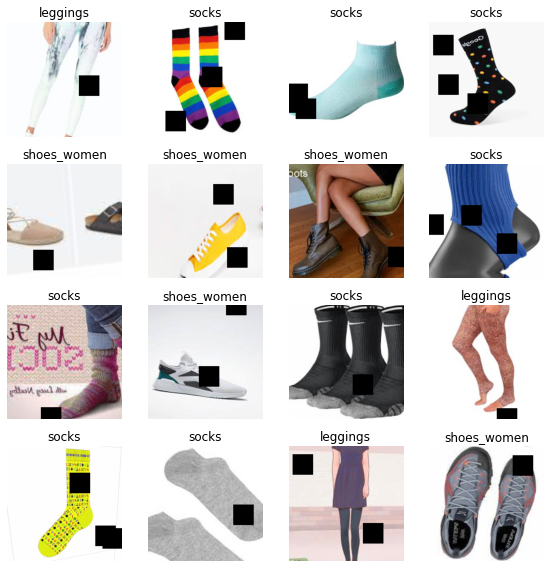

In [21]:
data.show_batch(rows=4, figsize=(8,8))

In [22]:
learn = cnn_learner(data,
                    models.resnet50,
                    metrics=error_rate)
learn.model.cuda()
learn.fit_one_cycle(10)
learn.save('cutout_stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,1.448872,0.805295,0.264591,01:16
1,1.156553,0.824023,0.245136,01:16
2,0.969574,0.629095,0.229572,01:18
3,0.777173,0.553827,0.221790,01:19
4,0.662762,0.498013,0.206226,01:40
5,0.559415,0.535815,0.245136,01:20
6,0.477546,0.507882,0.225681,01:19
7,0.413781,0.478417,0.186770,01:18
8,0.381658,0.486088,0.206226,01:18
9,0.340150,0.470159,0.198444,01:19


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


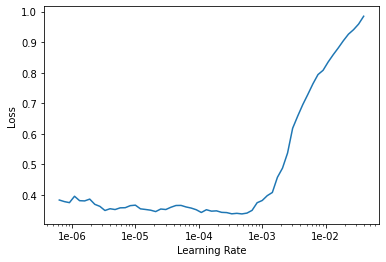

In [23]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))
learn.save('cutout_stage-2')

epoch,train_loss,valid_loss,error_rate,time
0,0.305575,0.469748,0.198444,01:25
1,0.315938,0.416662,0.186770,01:24
2,0.284694,0.443709,0.198444,01:24
3,0.268413,0.429048,0.178988,01:23
4,0.236291,0.420509,0.186770,01:23


Most confused categories (Actual, Predicted, Count):
[('shoes_men', 'shoes_women', 20), ('shoes_women', 'shoes_men', 13)]


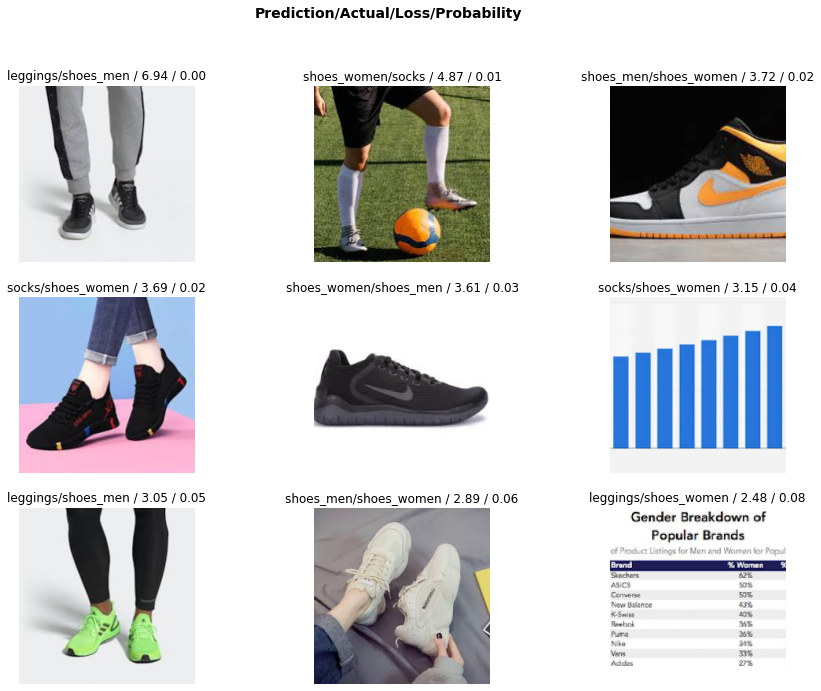

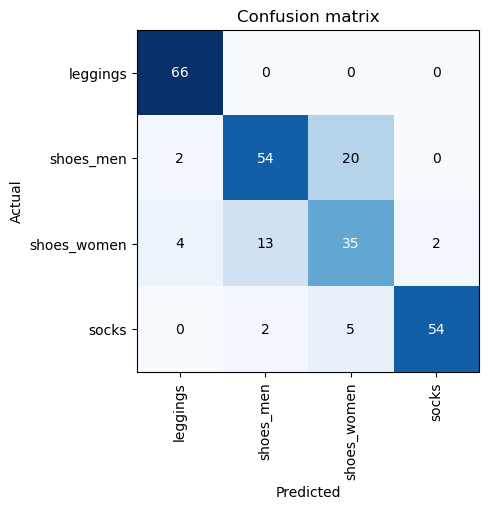

In [25]:
learn.load('cutout_stage-2')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize = (15,11))
interp.plot_confusion_matrix(figsize = (5,5), dpi = 100)
most_confused = interp.most_confused(min_val = 10)
print('Most confused categories (Actual, Predicted, Count):\n{}'.format(most_confused))

#### Cutout + Mixup & Label Smoothing

In [27]:
learn = cnn_learner(data,
                    models.resnet50,
                    metrics=error_rate,
                    loss_func=LabelSmoothingCrossEntropy()).mixup()
learn.model.cuda()
learn.fit_one_cycle(10)
learn.save('cutout_ls_mixup_stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,1.913653,1.182652,0.241245,01:18
1,1.789094,1.273297,0.322957,01:19
2,1.641676,1.016059,0.295720,01:19
3,1.412690,0.881633,0.241245,01:18
4,1.244783,0.807903,0.217899,01:17
5,1.135802,0.748980,0.210117,01:16
6,1.063654,0.724466,0.186770,01:15
7,0.998902,0.704588,0.194553,01:16
8,0.957588,0.709067,0.210117,01:16
9,0.937424,0.703249,0.202335,01:16


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


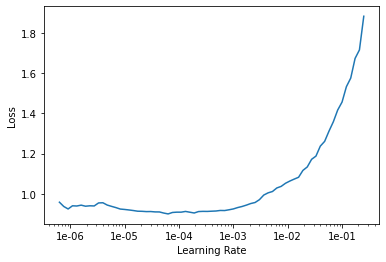

In [28]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))
learn.save('cutout_ls_mixup_stage-2')

epoch,train_loss,valid_loss,error_rate,time
0,0.907732,0.704378,0.202335,01:21
1,0.915946,0.694040,0.202335,01:21
2,0.902653,0.715140,0.225681,01:20
3,0.887770,0.698259,0.214008,01:20
4,0.859240,0.700343,0.202335,01:23


Most confused categories (Actual, Predicted, Count):
[('shoes_men', 'shoes_women', 25), ('shoes_women', 'shoes_men', 13)]


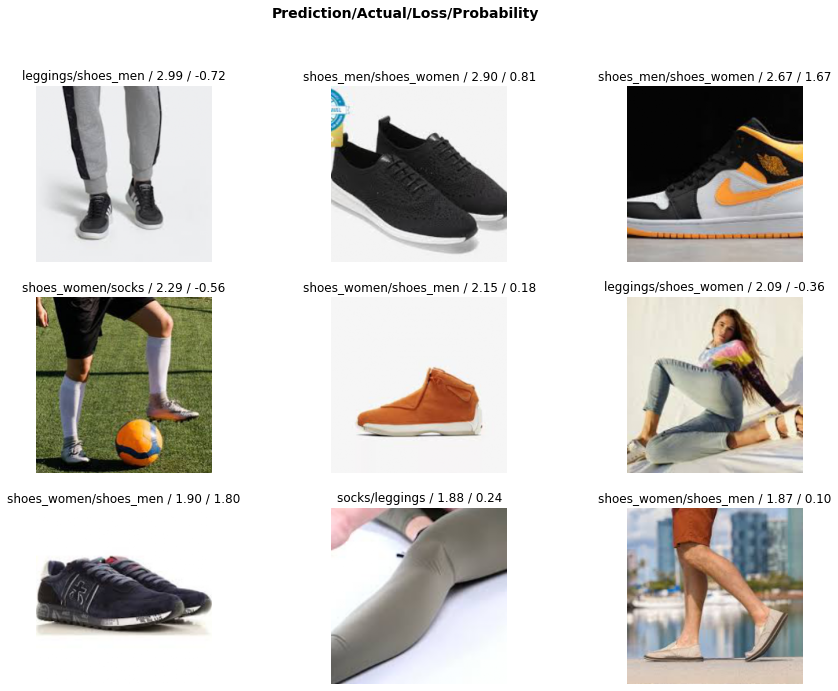

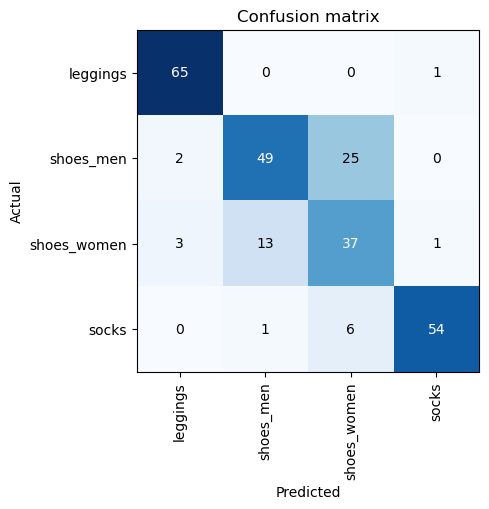

In [30]:
learn.load('cutout_ls_mixup_stage-2')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize = (15,11))
interp.plot_confusion_matrix(figsize = (5,5), dpi = 100)
most_confused = interp.most_confused(min_val = 10)
print('Most confused categories (Actual, Predicted, Count):\n{}'.format(most_confused))

### Save Models

In order to remain on one cycle throughout the entire training, we have to specify these parameters in `fit_one_cycle`:
- `cyc_len` (first argument)
    - the total number of epochs for the cycle (do not change this even if you are starting mid-cycle)
- `start_epoch`
    - the epoch you will restart training from (between 1 & `cyc_len`)
- `callbacks=[SaveModelCallback(...)]`
    - we save the weights after every epoch (`every='epoch'`)
    - in case we only want to save the best epoch, we can choose `every='improvement'`, using `monitor='error_rate'` to quantify improvements.

In [17]:
start = 22
learn.fit_one_cycle(30,
                    start_epoch = start,
                    callbacks=[SaveModelCallback(learn,
                                                 every='epoch',
                                                 monitor='error_rate',
                                                 name='resnet50_30te_cutout_mixup')])

Loaded resnet50_30te_cutout_mixup_21


epoch,train_loss,valid_loss,error_rate,time
22,1.648879,0.829137,0.217241,29:56
23,1.599334,0.824483,0.215912,31:04
24,1.604851,0.821494,0.214489,32:15
25,1.593274,0.815072,0.214157,31:56
26,1.546791,0.815933,0.214204,32:49
27,1.537701,0.812505,0.214109,34:24
28,1.574610,0.814327,0.213066,34:30
29,1.568347,0.808587,0.212781,36:12


##### --END--
This ends my notebook for Image Classification using FastAI.